# Creating cloud masks and generating atmospherically-corrected images
### Set instance (from sentinelhub free account (1 month trial!) and import relevant packages
#### Before running, make sure you start the docker so that the environments are correct - do this with: 
docker run -it --rm -p 8888:8888 -v $PWD/:/home/jovyan krostir/jupyter-geo-sentinelhub

#### For sentinelhub python package information visit https://sentinelhub-py.readthedocs.io/en/latest/examples/ogc_request.html

In [6]:
INSTANCE_ID = 'ce54ab2b-9dc3-4592-8a37-bbc96d450750'  # In case you put instance ID into cofniguration file you can leave this unchanged

In [1]:
from sentinelhub import *
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import datetime
import numpy as np

#sys.path.append('//home/maya/Dropbox/InternshipWUR/Scripting/sentinelhub/sentinel2-cloud-detector-master/s2cloudless')
import matplotlib.pyplot as plt
from s2cloudless import *


from glob import glob
import os

import numpy.ma as ma
import pandas as pd
from matplotlib import patches as mpatches, colors
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import seaborn as sns

import rasterio
import geopandas as gpd
from shapely.geometry import mapping

#import earthpy as et
#import earthpy.spatial as es

plt.ion()
sns.set_style('white')
sns.set(font_scale=1.5)

#os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))


ImportError: libncurses.so.6: cannot open shared object file: No such file or directory

#### Defining function to plot tiles

In [8]:
def plot_image(image, factor=1):
    """
    Utility function for plotting RGB images.
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))

    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1))
    else:
        plt.imshow(image)

#### Define cloud masker functions

In [9]:
def overlay_cloud_mask(image, mask=None, factor=1./255, figsize=(15, 15), fig=None):
    """
    Utility function for plotting RGB images with binary mask overlayed.
    """
    if fig == None:
        plt.figure(figsize=figsize)
    rgb = np.array(image)
    plt.imshow(rgb * factor)
    if mask is not None:
        cloud_image = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.uint8)
        cloud_image[mask == 1] = np.asarray([255, 255, 0, 100], dtype=np.uint8)
        plt.imshow(cloud_image)

In [10]:
def plot_probability_map(rgb_image, prob_map, factor=1./255, figsize=(15, 30)):
    """
    Utility function for plotting a RGB image and its cloud probability map next to each other. 
    """
    plt.figure(figsize=figsize)
    plot = plt.subplot(1, 2, 1)
    plt.imshow(rgb_image * factor)
    plot = plt.subplot(1, 2, 2)
    plot.imshow(prob_map, cmap=plt.cm.inferno)

In [11]:
def plot_cloud_mask(mask, figsize=(15, 15), fig=None):
    """
    Utility function for plotting a binary cloud mask.
    """
    if fig == None:
        plt.figure(figsize=figsize)
    plt.imshow(mask, cmap=plt.cm.gray)

In [12]:
def plot_previews(data, dates, cols=4, figsize=(15, 15)):
    """
    Utility to plot small "true color" previews.
    """
    width = data[-1].shape[1]
    height = data[-1].shape[0]
    
    rows = data.shape[0] // cols + (1 if data.shape[0] % cols else 0)
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    for index, ax in enumerate(axs.flatten()):
        if index < data.shape[0]:
            caption = '{}: {}'.format(index, dates[index].strftime('%Y-%m-%d'))
            ax.set_axis_off()
            ax.imshow(data[index] / 255., vmin=0.0, vmax=1.0)
            ax.text(0, -2, caption, fontsize=12, color='g')
        else:
            ax.set_axis_off()

#### Setting AOI

In [13]:
hardangervidda_coords_wgs84 = [8.3018, 60.3967,6.7596,59.9] #rectangle for AOI
hardanger_bbox = BBox(bbox=hardangervidda_coords_wgs84, crs=CRS.WGS84) #bounding box, interpretable by sentinelhub

#### WMS request for multiple true colour images, within time window.
Width and height set - can also just set one, and the other will adjust automatically

In [84]:
wms_true_color_request = WmsRequest(layer='TRUE-COLOR-S2-L1C',
                                    bbox=hardanger_bbox,
                                    time=('2017-10-01', '2017-10-31'),
                                    width=600, #height=856,
                                    instance_id=INSTANCE_ID,
                                    maxcc=0.5,
                                    custom_url_params={CustomUrlParam.ATMFILTER: 'ATMCOR',
                                                   CustomUrlParam.TRANSPARENT: True,
                                                   CustomUrlParam.SHOWLOGO: False})

In [85]:
#wms_true_color_img = wms_true_color_request.get_data()
wms_true_color_img = wms_true_color_request.get_data()

In [16]:
print('There are %d Sentinel-2 images available for 2017.' % len(wms_true_color_img))
print(type(wms_true_color_img))
print(type(wms_true_color_img[1]))
print(type(wms_true_color_request))

There are 8 Sentinel-2 images available for 2017.
<class 'list'>
<class 'numpy.ndarray'>
<class 'sentinelhub.data_request.WmsRequest'>


#### Preview the data queried

TypeError: Invalid dimensions for image data

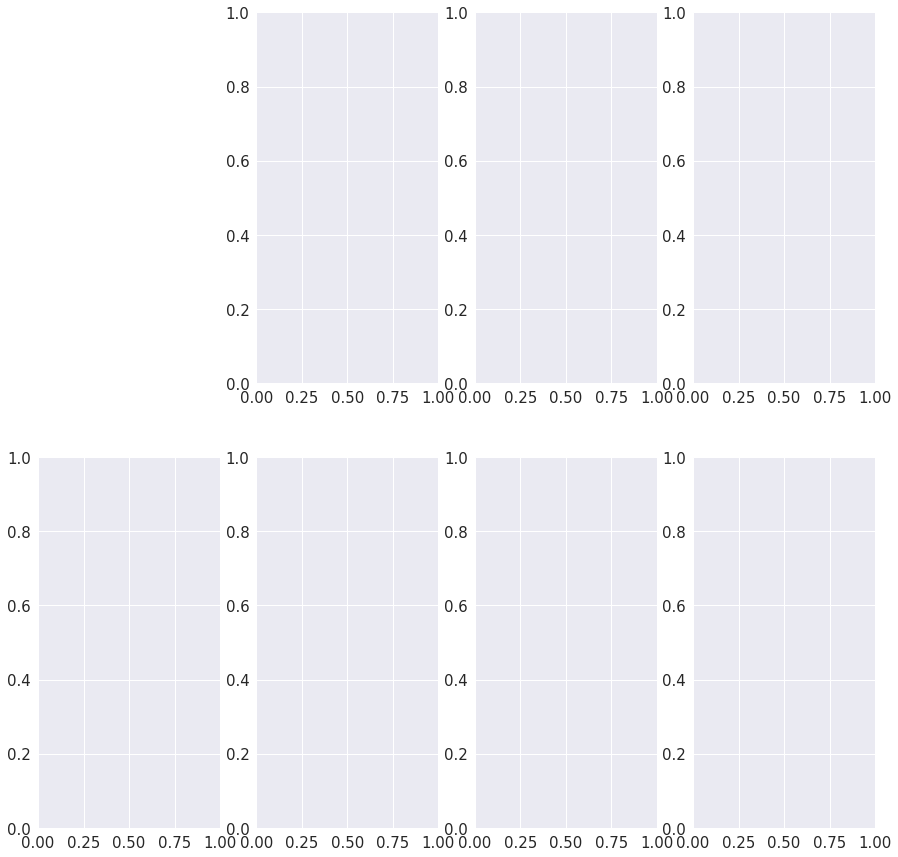

In [87]:
plot_previews(np.asarray(wms_true_color_img), wms_true_color_request.get_dates(), cols=4, figsize=(15, 10))

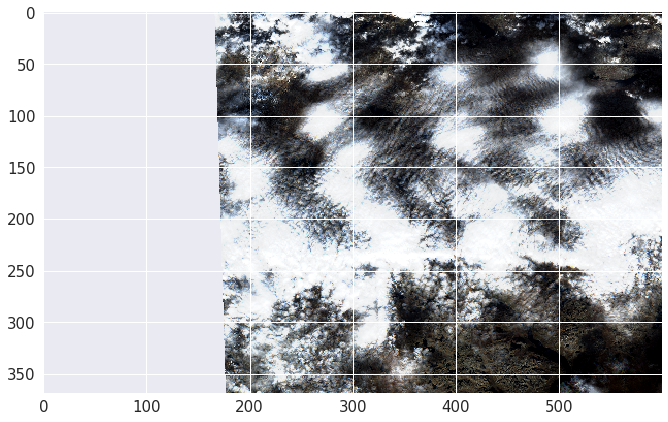

In [18]:
plot_image(wms_true_color_img[4])

In [19]:
print('These %d images were taken on the following dates:' % len(wms_true_color_img))
for index, date in enumerate(wms_true_color_request.get_dates()):
    print(' - image %d was taken on %s' % (index, date))

These 8 images were taken on the following dates:
 - image 0 was taken on 2017-10-06 10:59:37
 - image 1 was taken on 2017-10-08 10:50:12
 - image 2 was taken on 2017-10-09 11:09:46
 - image 3 was taken on 2017-10-14 11:09:59
 - image 4 was taken on 2017-10-16 11:03:13
 - image 5 was taken on 2017-10-18 10:50:26
 - image 6 was taken on 2017-10-28 10:51:28
 - image 7 was taken on 2017-10-29 11:11:56


## Cloud masking 
### Make a new WMS request - note: cannot have atmospheric correction activated - interferes with result

In [20]:
bands_script = 'return [B01,B02,B04,B05,B08,B8A,B09,B10,B11,B12]'

In [88]:
wms_bands_request = WmsRequest(layer='TRUE-COLOR-S2-L1C',
                               custom_url_params={
                                   CustomUrlParam.EVALSCRIPT: bands_script,
                                   CustomUrlParam.ATMFILTER: 'NONE'},#or ATMCOR
                               bbox=hardanger_bbox, 
                               maxcc=0.5,
                               time=('2017-10-01', '2017-10-30'), 
                               width=600, height=None,
                               image_format=MimeType.TIFF_d32f,
                               #image_format=MimeType.TIFF_d32f,
                               instance_id=INSTANCE_ID)

wms_bands_cor_request = WmsRequest(layer='TRUE-COLOR-S2-L1C',
                                   custom_url_params={
                                       CustomUrlParam.EVALSCRIPT: bands_script,
                                       CustomUrlParam.ATMFILTER: 'ATMCOR'},#or ATMCOR
                                   bbox=hardanger_bbox, 
                                   maxcc=0.5,
                                   time=('2017-10-01', '2017-10-30'), 
                                   width=600, height=None,
                                   image_format=MimeType.TIFF_d32f,
                                   instance_id=INSTANCE_ID)

In [89]:
wms_bands = wms_bands_request.get_data()
wms_bands_cor = wms_bands_cor_request.get_data()

In [23]:
cloud_detector = S2PixelCloudDetector(threshold=0.4, average_over=4, dilation_size=2)

In [24]:
cloud_probs = cloud_detector.get_cloud_probability_maps(np.array(wms_bands))

In [25]:
cloud_masks = cloud_detector.get_cloud_masks(np.array(wms_bands))

## Visualise the results

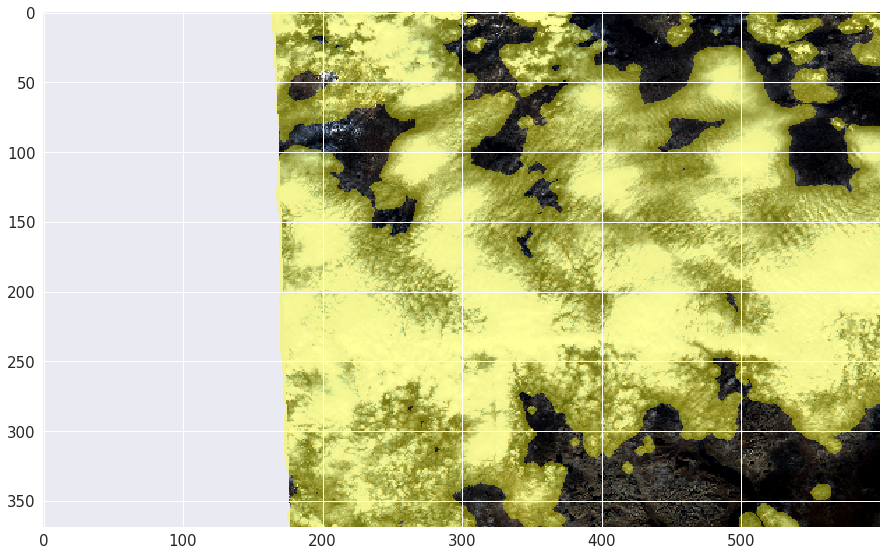

In [26]:
image_idx = 4
overlay_cloud_mask(wms_true_color_img[image_idx], cloud_masks[image_idx])

In [93]:
#plot_probability_map(wms_true_color_img[image_idx], cloud_probs[image_idx])

In [92]:
#plot_cloud_mask(cloud_masks[image_idx])

### Set value below cloud mask to NoData

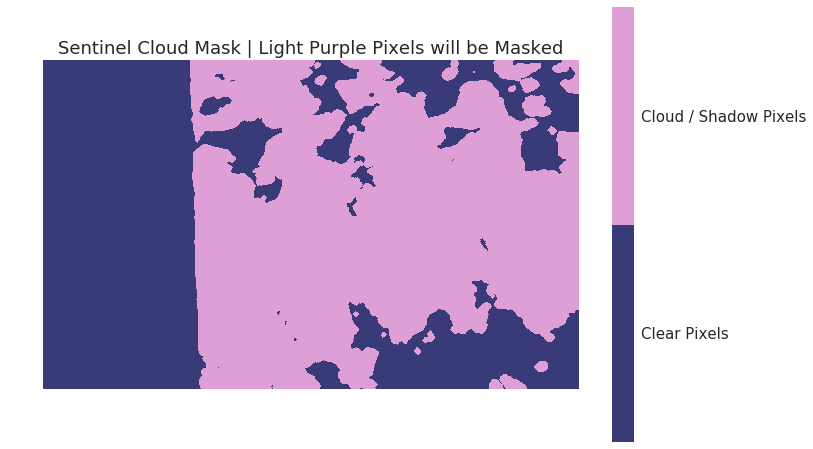

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(cloud_masks[image_idx],
               cmap=plt.cm.get_cmap('tab20b', 2))
cbar = fig.colorbar(im)
cbar.set_ticks((0.25, .75))
cbar.ax.set_yticklabels(["Clear Pixels", "Cloud / Shadow Pixels"])
ax.set_title("Sentinel Cloud Mask | Light Purple Pixels will be Masked")
ax.set_axis_off()

plt.show()

In [30]:
print(cloud_masks.shape)
type(cloud_masks[2])

(8, 369, 600)


numpy.ndarray

In [31]:
def inpaint(originalImage, mask):
    [rows, columns, channels] = originalImage.shape
    result = np.zeros((rows,columns,channels))
    for row in range(rows):
        for column in range(columns):
            if(mask[row,column]==0):
                result[row,column] = originalImage[row,column]
            else:
                result[row,column] = (0,0,255)
    return result

In [95]:
#result = wms_true_color_img[image_idx].copy()
result= wms_bands[image_idx].copy()
mask2d=cloud_masks[image_idx].copy()
cloud_masks[image_idx].shape

(369, 600, 10)

#### copy mask x times (no. of bands)

In [97]:
mask3d = np.repeat(cloud_masks[image_idx][:, :, np.newaxis], 10, axis=2)
mask3d.shape

(369, 600, 10)

following solutions are two ways of doing the same thing and seem correct

In [98]:
sentinel_pre_mask = np.broadcast_to(mask3d==1, result.shape)
sentinel_pre_cl_free = np.ma.masked_array(result,mask=sentinel_pre_mask)
#resultmasked = np.ma.masked_array(result[1],mask=cloud_masks[4])
resultmasked=np.ma.array(result,mask=mask3d)

#xm2=np.ma.array(result, mask=result*m3d)
#plot_image(sentinel_pre_cl_free)
#plot_image(sentinel_pre_cl_free)
#plot_image(resultmasked)
spm= np.broadcast_to(mask3d==1, result.shape)
np.unique(spm)
spcf = np.ma.masked_array(result,mask=spm)

masked=spcf.data

TypeError: Invalid dimensions for image data

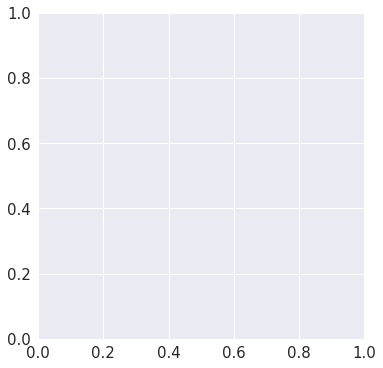

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.imshow(resultmasked,        
          extent=hardanger_bbox,
          cmap="Greys")
ax.set(title="Sentinel CIR Composite Image | Octoer 2017")
ax.set_axis_off()

In [36]:
array = np.random.random((3,3))
condition = np.random.randint(0, 2, (3,3))
masked = np.ma.array(array, mask=condition)

masked += 2.0

masked.mask = False
hasattr(masked, 'mask')
np.unique(masked.mask)

array([False])

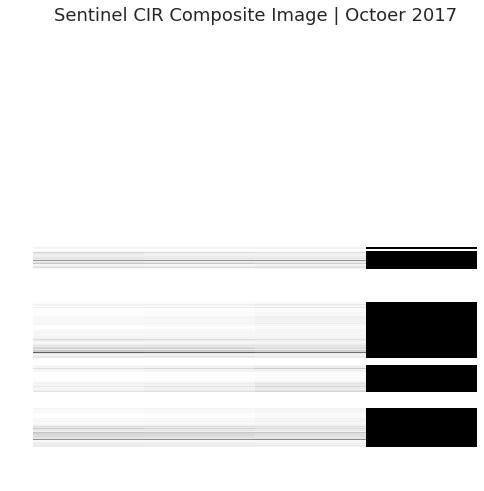

In [37]:
fig, ax = plt.subplots(1,1,figsize=(12, 8))

ax.imshow(sentinel_pre_cl_free[3],        
          extent=hardanger_bbox,
          cmap="Greys")
ax.set(title="Sentinel CIR Composite Image | Octoer 2017")
ax.set_axis_off()



In [68]:
_, mask_b = np.broadcast_arrays(result, mask[..., None])
xm  = np.ma.masked_array(result, mask_b)

field3d_mask = np.zeros(result.shape)
field3d_mask[:,:,:] = mask[:,:,np.newaxis] > 0

xm1=np.ma.masked_array(result,field3d_mask)
field3d_mask

#xm2=np.ma.array(result, mask=result*mask[:,:,np.newaxis])
#masker = mask.shape + (1,)


#print(xm2)
#print(mask)
#print(result)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [ ]:
#sentinel_pre_mask = np.broadcast_to(mask2d == 1,result)
cl_mask = np.zeros(mask2d.shape)

for cval in mask2d:
    # create cloud mask for all relevant cloud values, for the primary scene
    cl_mask[mask2d == cval] = 1
    #print(cval)
np.unique(cl_mask)
mask2d.shape

#cl_mask
#mask3d= np.broadcast_to(mask2d, (369,600,4))

In [ ]:
m = mask2d>0
#resultmasked=np.ma.array(result,mask=m)
landsat_pre_mask = np.broadcast_to(mask3d, result.shape)

np.where(m==True)
#landsat_pre_cl_free = ma.masked_array(result,mask=landsat_pre_mask)

#result[mask!=0] = (0,0,255)
#print(type(result))

## Check out following sources:
### more assistance on masking over multiple dimensions perhaps...
https://www.earthdatascience.org/courses/earth-analytics-python/multispectral-remote-sensing-modis/cloud-masks-with-spectral-data-python/ 
https://geohackweek.github.io/nDarrays/09-masking/ 